# Algunos ejemplos de visualización en `GAP`

## Usando lenguage `dot`

Podemos crear funciones en `GAP` cuya salida sea una cadena de caracteres en `dot` (véase [graphviz](http://graphviz.org/)). Luego, podemos pasar esa salida a `JupyterSplashDot`.

In [1]:
RelToDotNS:=function(uni, rel,labels)

  local r, output, out, i, str;

  str:=function(s)
    return Concatenation("\"",String(s),"\"");
  end;

  out:="";
  output:=OutputTextString(out,true);
  AppendTo(output,"graph  NSGraph{");
  for i in [1..Length(uni)] do
    AppendTo(output,i," [label=",str(labels[i]),"];");
  od;
  for r in rel do
    AppendTo(output,Position(uni,r[1])," -- ",Position(uni,r[2]),";");
  od;
  AppendTo(output,"}");
  CloseStream(output);
  return out;
end;

function( uni, rel, labels ) ... end

Para dibujar diagramas de Hasse, eliminamos la reflexividad y las relaciones que se deducen de otras por transitividad.

In [2]:
hasse:=function(dom,rel)
    local out;
    
    out:=Filtered(rel, p-> p[1]=p[2] or ForAny(Difference(dom,p), x->([p[1],x] in rel) and ([x,p[2]] in rel)));
    
    return Difference(rel,out);
end;

function( dom, rel ) ... end

Con esto, como ejemplo, vamos a dibujar el retículo de subespacios de $\mathbb{Z}_5^2$.

In [3]:
InstallMethod(ViewString, [IsVectorSpace], function(v) return("Vector space"); end);

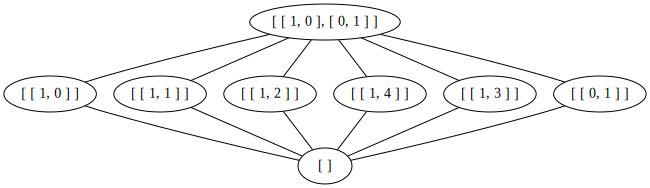

In [9]:
sz:= Subspaces(GF(5)^2);;
un:=List(sz);;
rels:=Filtered(Cartesian(un,un),p->IsSubspace(p[1],p[2]));;
h:=hasse(un,rels);;
lab:=List(sz,w->List(Basis(w),x->List(x,Int)));;
JupyterSplashDot(RelToDotNS(un,h,lab));

También podemos dibujar el retículo de divisores de un entero.

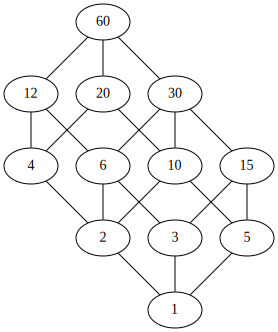

In [13]:
un:=DivisorsInt(60);;
rels:=Filtered(Cartesian(un,un),p->p[1] mod p[2]=0);;
h:=hasse(un,rels);;
JupyterSplashDot(RelToDotNS(un,h,un));

## `jupyterviz`
Una de las posibilidades es utilizar `jupyterviz`. En este bloc usamos la versión 1.3.

In [14]:
LoadPackage("jupyterviz");

true

Vamos a representar el número de formas distintas en las que podemos comprar $n$ nuggets de pollo si las cajas disponibles son de 6, 9 y 10 nuggets, respectivamente.

In [15]:
Plot([20..50], x->Length(RestrictedPartitions(x,[6,9,10])), 
 rec(
title := "Número de formas distintas en las que se pueden comprar nuggets",
          xaxis := "n",
yaxis := "número de expresiones de n", type:="bar"
      ));

Le vamos a añadir ahora una segunda gráfica que represente el mínimo número de cajas necesarias para comprar $n$ nuggets.

In [19]:
l:=[6,9,10];;
Plot([[50..100], x->Length(RestrictedPartitions(x,l)), 
 rec(
title := "Número de formas en las que se pueden comprar nuggets",
          xaxis := "n",
yaxis := "número de expresiones de n", type:="bar", name:="posibilidades"
)], 
[[50..100], x->Minimum(List(RestrictedPartitions(x,l),Length)), 
 rec(
type:="line", title:="Mínimo número de cajas necesarias", name:="min # cajas",
)]
);

Ponemos un tipo de caja más, con 13 nuggets.

In [21]:
l:=[6,9,10,13];;
Plot([[50..100], x->Length(RestrictedPartitions(x,l)), 
 rec(
title := "Número de formas en las que se pueden comprar nuggets",
          xaxis := "n",
yaxis := "número de expresiones de n", type:="bar", name:="posibilidades"
)], 
[[50..100], x->Minimum(List(RestrictedPartitions(x,l),Length)), 
 rec(
type:="line", title:="Mínimo número de cajas necesarias", name:="min # cajas"
)]
);

Veamos ahora la proporción que tiene cada número posible de cajas en todas las formas posibles que tenemos de comprar 100 nuggets. En este ejemplo 100 se puede conseguir con un mínimo de 12 cajas, y un máximo de 25. El número de cajas más frecuente entre todas las posibilidades es 17.

In [24]:
p:=RestrictedPartitions(100,[4,6,9]);;
ls:=List(p,Length);;
Plot(Set(ls),x->Length(Filtered(ls,l->l=x)), rec(type:="pie", height:=500, 
title:="Número de formas de comprar 100 nuggets clasificadas por el número de cajas necesarias"));

Ahora representamos la misma idea con un gráfico de frecuencias.

In [25]:
Plot(Set(ls),x->Length(Filtered(ls,l->l=x)), rec(xaxis:="Número de cajas necesarias para 100 nuggets", 
yaxis:="Número de posibilidades"));

También podemos dibujar grafos. El siguiente grafo representa las relaciones de divisibilidad (quitamos las que se deducen por transitividad y reflexividad con `hasse`).

In [27]:
d:=DivisorsInt(24);;
PlotGraph(d, hasse(d,Filtered(Cartesian(d,d), p->p[2] mod p[1]=0)), 
    rec(directed:=true, layout:="circle", arrowscale:=2)
);

## `francy`

Otra posibilidad es utilizar `francy` que además tiene `callbacks`. Podemos crear visualizaciones interactivas. En el ejemplo que mostramos abajo, se crea el retículo de divisores de un entero. Cuando el ratón pasa por un nodo escribirá su factorización, y cuando hagamos click en él mostrará un mensaje dando esa información.

In [29]:
LoadPackage("francy");

true

In [30]:
pinta_divisores:=function(x)
    local hasse, muestrafacts,graphHasse,d, ds, canvas, message, c, i ,r, n;
    hasse:=function(rel)
      local dom, out;
      dom:=Flat(rel);
      out:=Filtered(rel, p-> ForAny(dom, x->([p[1],x] in rel) and ([x,p[2]] in rel)));
      return Difference(rel,out);
    end;


    muestrafacts:=function(x)
        message := FrancyMessage(Concatenation(String(x), " factoriza como "), 
            String(Factors(x)));
        SetFrancyId(message, Concatenation("message-for-", String(x)));
        Add(canvas, message);
        return Draw(canvas);
    end;

  
    graphHasse := Graph(GraphType.UNDIRECTED);
    #SetSimulation(graphHasse,true);
    #SetDrag(graphHasse,true);
    d:=DivisorsInt(x);
    n:=Length(d);
    c:=Cartesian([1..n],[1..n]);
    c:=Filtered(c, p-> p[2]<>p[1]);
    c:=Filtered(c, p-> d[p[2]] mod d[p[1]]=0);
    c:=hasse(c);
    ds:=[];
    for i in [1..n] do
        ds[i]:=Shape(ShapeType!.CIRCLE, String(d[i]));
        SetLayer(ds[i],-d[i]);
        Add(ds[i],Callback(muestrafacts,[d[i]]));
        Add(ds[i],FrancyMessage(String(Factors(d[i]))));
        Add(graphHasse,ds[i]);
    od;
    for r in c do
        Add(graphHasse,Link(ds[r[1]],ds[r[2]]));
    od;
    canvas:=Canvas("Divisores");
    Add(canvas,graphHasse);
    return Draw(canvas);    
end;

function( x ) ... end

In [31]:
pinta_divisores(12);